In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

In [3]:
v_data, e_data, v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter()

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.04 s
PREPROCESSING: 1.05 s


In [4]:
# Sort based on testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
-1.0    126863
 0.0     13769
 1.0      1244
Name: testingFlag, dtype: int64
Address :
-1.0    28432
 0.0     1568
Name: testingFlag, dtype: int64
Customer :
-1.0    42127
 0.0    13650
 1.0      449
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    27286
 0.0     3925
 1.0       63
Name: testingFlag, dtype: int64
External Entity :
-1.0    55207
 0.0     4757
 1.0       36
Name: testingFlag, dtype: int64


In [5]:
for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

In [6]:
batch_size = 200
epochs = 20
num_samples = [8, 4]
dropout = 0.4
hinsage_layer_sizes = [32, 32]

In [7]:
G = sg.StellarDiGraph(v_sets, e_sets)

# step 1. create hinsage model

In [8]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

def make_hinsage():
    return HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

hinsage = make_hinsage()

# step 2. pretrain with infomax

In [9]:
def run_deep_graph_infomax(base_model, generator, epochs):
    t0 = time.time()
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    t1 = time.time()
    print(f'Time required: {t1-t0:.2f} s ({(t1-t0)/60:.1f} min)')
    
    return x_emb_in, x_emb_out, model

Epoch 1/20
710/710 [==============================] - 79s 112ms/step - loss: 0.4396
Epoch 2/20
710/710 [==============================] - 81s 115ms/step - loss: 0.3554
Epoch 3/20
710/710 [==============================] - 79s 112ms/step - loss: 0.29330s - loss: 0.29
Epoch 4/20
710/710 [==============================] - 77s 109ms/step - loss: 0.250014s - loss:  - ETA - ETA: 12s - loss: 0.25 - ETA: 12s - loss: 0.25 - ETA:  - ETA: 11s - loss: 0 - ETA: 3s - 
Epoch 5/20
710/710 [==============================] - 74s 105ms/step - loss: 0.2133
Epoch 6/20
710/710 [==============================] - 79s 111ms/step - loss: 0.1816
Epoch 7/20
710/710 [==============================] - 75s 105ms/step - loss: 0.1606
Epoch 8/20
710/710 [==============================] - 78s 110ms/step - loss: 0.14462s - loss: 0.1 - ETA: 2s - los - ETA: 1s -
Epoch 9/20
710/710 [==============================] - 77s 108ms/step - loss: 0.12990s - loss: 0.12
Epoch 10/20
710/710 [==============================] - 76s 106ms

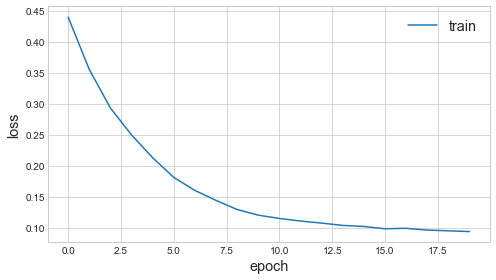

In [10]:
pretrained_x_in, pretrained_x_out, pretrained_model = run_deep_graph_infomax(hinsage, generator, epochs)

pretrained_x_out represents the 32 dimensional embeddings of the nodes in the network. With a Dense softmax layer, I'm going to "squeeze" them to a 2219 length array, which is a one-hot-encoding of the output classes (2219 different Extended Case classes for Account nodes).
The model basically becomes trained end2end

# step 3. fine tune model

In [13]:
# split training + cv datasets
train_cv_set = v_sets['Account'][126863:126863+13769]

# these are the training+cv indexes
node_ids = train_cv_set.index.values.tolist()

# these are the training+cv Extended case ID
v_data.ExtendedCaseGraphID = v_data.ExtendedCaseGraphID.fillna(0)
ext_targets_2 = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID

# Train set & labels
train_set = train_cv_set[:10000]
train_labels = ext_targets_2.values[:10000]

# CV set & labels
cv_set = train_cv_set[-3769:]
cv_labels = ext_targets_2.values[-3769:]

# test set
test_set = v_sets['Account'][-1244:]

In [34]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
cv_targets = target_encoding.transform(cv_labels)

train_gen = generator.flow(train_set.index, train_targets)
cv_gen = generator.flow(cv_set.index, cv_targets)

In [35]:
# Since they are int and not categorical, 
# try without onehot encoding maybe?

'''
train_targets = train_labels
cv_targets = cv_labels

train_gen = generator.flow(train_set.index, train_targets)
cv_gen = generator.flow(cv_set.index, cv_targets)
'''
# it turns out the loss stays at 0.0000 always

'\ntrain_targets = train_labels\ncv_targets = cv_labels\n\ntrain_gen = generator.flow(train_set.index, train_targets)\ncv_gen = generator.flow(cv_set.index, cv_targets)\n'

In [36]:
n_classes = len(np.unique(train_labels))

pretrained_predictions = Dense(
    units=n_classes, 
    #units=1,
    activation="softmax"
)(pretrained_x_out)

In [44]:
from sklearn.utils.class_weight import compute_class_weight

cw = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

In [38]:
tuned_model = Model(
    inputs=pretrained_x_in, 
    outputs=pretrained_predictions
)

tuned_model.compile(
    optimizer=Adam(lr=0.01),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

es = EarlyStopping(
    monitor='val_acc',
    patience=50,
    restore_best_weights=True
)

In [39]:
tuned_epochs = 4

In [45]:
tuned_history = tuned_model.fit(
    train_gen,
    epochs=tuned_epochs,
    verbose=1,
    validation_data=cv_gen,
    callbacks=[es],
    class_weight=cw,
)
sg.utils.plot_history(tuned_history)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
tuned_model.predict(test_set)

AssertionError: in user code:

    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("dense_1/Softmax:0", shape=(None, 1), dtype=float32)
